# Group Project: TorchText를 이용한 Naver Article 분류 구현

In [0]:
## 필요한 모듈
import numpy as np
import pandas as pd
import torch
from torchtext.data import Field
from torchtext.data import LabelField
import konlpy
from konlpy.tag import Okt
import hanja

## Specs
- https://github.com/bentrevett/pytorch-sentiment-analysis 는 Pytorch, TorchText를 이용하여 IMDB 분류를 다양한 방법으로 행하고 있는 사이트이다.
- 이 사이트를 참고로 하여, Naver News Review를 TorchText를 이용하여 분류하는 프로그램을 구현하라.
- 3명 이내의 그룹이나 혼자해도 무방!
- 여러 가능한 딥러닝 모듈을 사용할 수 있고(Transformer는 제외), 같이 제공되는 이 영화평으로 학습된 word2vec 임베딩을 반드시 포함하여야 한다.
- TorchText는 제공되는 이외의 임베딩은 따로 구현해야 하기 때문에 한국어 임베딩을 TorchTExt에 통합시키는 방법을 모색해 보라.
- 그룹으로 하는 경우 파일 이름 FinalProjectYOURGroupName.ipynb로 하고 요약에 참가자들 학번과 명단을 명시해야 함. 그룹명은 자유롭게 할 수 있으나 너무 길지 않도록
- 혼자하는 경우 그룹명에는 학번이 들어가야함(FinalProject2019_01234.ipynb)
- 아래 셀은 가이드로 제시된 것이니 필요에 따라 수정할 수 있음
- 마감: 6월 4일 수업시간 전까지
- 참고 사이트
    - https://pytorch.org/text/
    - http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
    - https://github.com/pytorch/text 
    - https://mc.ai/using-fine-tuned-gensim-word2vec-embeddings-with-torchtext-and-pytorch/
    - 조교가 올린 newsdata 모델

# **구현 요약**

### **구성원**
정소영
이지은

### **전처리의 특징**
1. 특수문자 제거: '...''·'와 같은 특수문자를 제거했다.
2. 한자어는 한글로 변환했다.
3. 기사의 헤드라인과 본문 내용을 토큰화하여 vocab으로 저장하고 그 중 1음절은 제거했다.

### **사용한 형태소 분석기**
Twitter(Okt)를 사용했다. 

Mecab, Komoran은 Jpype와 konlpy 사이의 버전 충돌 문제로 인해 사용하지 못했다. 

vocab 개수 : 19195



### **사용한 어휘들의 특징 및 vocab 개수**
Twitter 형태소 분석기를 사용하여 명사만 추출했고, 총 vocab 개수는 19195개 였다.  
명사와 동사를 포함하여 vocab을 만들어보았으나, 정확도가 유의미하게 향상되지 않아 명사만 사용하는 것을 선택했다. 


### **사용한 모델**
- 주로 Sentiment Analysis - 2. Upgraded Sentiment Analysis를 참고했다.

    이 모델의 특징은 다음과 같다.

1. packed padded sequences
2. pre-trained word embeddings
3. different RNN architecture(=LSTM)
4. bidirectional RNN
5. multi-layer RNN
6. regularization

#### 시퀀스 데이터이기 때문에 CNN보다 RNN을 선택했고 정확도가 높은 LSTM을 사용했다.
#### CNN을 사용했을 때는 속도는 빨라졌지만 정확도에 유의미한 차이가 있지 않았다.


- 분류 라벨이 여러개이므로 5. Multi-Class Sentiment Analysis도 참고했다.

    다음 두 가지를 활용했다.
1. LABEL = data.LabelField()
2. OUTPUT_DIM = len(LABEL.vocab)


### **하이퍼패러미터 값**
1. batch size: 64 (train 데이터의 개수인 1280의 약수 중 가장 좋은 정확도를 보여서 선택했다)  
2. input size : 19195 (len(vocab)의 값이다.)   
3. optimizer: Adamax (Adam 계열 중에 가장 높은 정확도와 예측능력을 보였다.)
4. hidden layer : 256
5. epoch : 25


### **성능**
위와 같이 하이퍼패러미터를 정했을 때, 82.19 %의 정확도를 보였다.   
다음은 모든 조건을 위와 같이 했을 때, optimizer의 종류만을 바꾸며 정확도를 비교하여 표로 정리한 것이다. 

||SGD|SGD Nesterov|Adam|Adadelta|Adamax|Adagrad|RMSProp|
|---------|---------|---------|---------|---------|---------|---------|---------|
|accuracy|17.19|53.12|80.00|77.81|82.19|84.09|51.25|


### **결과**

82.19%의 정확도를 가진 Adamax를 썼을 때 첫번째 기사제목만 예측하지 못하였다.
80%의 정확도를 가진 Adam을 썼을 때는 첫번쨰와 두번째 기사제목은 예측하지 못했지만 나버지 여섯개는 예측했다. 다른 optimizer들도 첫번째와 두번쨰 기사제목을 예측하지 못했는데, 세계를 정치와 혼동하고 연예를 사회/문화와 혼동하는 이유에 대한 자세한 분석은 뒷부분에 추가했다.


###  **참고사항**

매 실행시마다 build_voca 의 결과가 달라지기 때문에 학습정도와 정확도, 예측값에도 영향을 준다.
현재 셀 실행 후 남아 있는 데이터는 런타임 초기화 이후 실행했기 때문에 위에 언급한 값과 다르다.

## 데이터 
- 제공되는 데이터는 Naver News 데이터의 헤드라인과 본문을 합친 news 컬럼이 있는 데이터
![%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202020-05-17%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.45.36.png](attachment:%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202020-05-17%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.45.36.png)

## Tokenizer 구현

In [0]:
def tokenizer(string):
  string.replace("...", "")
  string.replace("·", "")
  string = hanja.translate(string, 'substitution')
  okt = Okt()
  nouns = okt.nouns(string)
  nouns = [a for a in nouns if len(a) > 1]
  
  return nouns

In [0]:
TEXT = Field(sequential=True, tokenize = tokenizer, include_lengths = True)
LABEL = LabelField()

## Data Connecting to Raw Data 
- TorchTExt를 이용하여, Naver News Data를 불러오고, TEXT, LABEL로 연결
- 불러온 데이터를 train, test 데이터로 나누고(8:2비율) train 데이터로 vocab을 형성

In [0]:
df = pd.read_table("./newsdataCombined.tsv", sep='\t')
df.head(2)

,filename,headline,body,label,news
0,1125NewsData.txt,"감자·무 가격 고공행진…정부, 밥상물가 잡기 '안간힘'","""평양냉면 인기도 뭇값 강세에 일조""…가격 뛴 상품 수입·조기 출하\n\n\n(세종...",1,"감자·무 가격 고공행진…정부, 밥상물가 잡기 '안간힘'\n\n""평양냉면 인기도 뭇값..."
1,0050NewsData.txt,"대법 ""'최순실 주치의' 이임순 교수 위증혐의 기소 '위법'""","""국조특위 활동 종료 후에는 고발 못 해""…'공소기각' 2심 판결 확정\n\n\n(...",0,"대법 ""'최순실 주치의' 이임순 교수 위증혐의 기소 '위법'""\n\n""국조특위 활동..."


In [0]:
#전체 데이터를 raw_data로 불러들이기

from torchtext.data import TabularDataset

raw_datafields = [("filename", None), ("headline", None), ("body", None), ("label", LABEL), ("news", TEXT)]

raw_data = TabularDataset(path="./newsdataCombined.tsv", format='tsv', skip_header=True, fields=raw_datafields)

In [0]:
# TO check imported raw Data
print(f'Number of All examples: {len(raw_data)}')
print(vars(raw_data.examples[0]))

Number of All examples: 1600
{'label': '1', 'news': ['감자', '가격', '고공', '행진', '정부', '밥상', '물가', '잡기', '안간힘', '평양', '냉면', '인기', '강세', '일조', '가격', '상품', '수입', '조기', '출하', '세종', '연합뉴스', '이태수', '기자', '감자', '일부', '농산물', '가격', '정부', '상승', '밥상', '물가', '대란', '우려', '진정', '위해', '정부', '농림축산식품부', '급등', '농산물', '조기', '출하', '골자', '주요', '품목', '수급', '상황', '전망', '향후', '대책', '주요', '농산물', '가격', '점차', '안정화', '농식품부', '최근', '농산물', '가격', '한파', '지난달', '일시', '저온', '일조', '부족', '작황', '하량', '평년', '시세', '보이', '감자', '평년', '대비', '시세', '양파', '마늘', '재배', '면적', '증가', '시세', '우려', '설명', '감자', '지난해', '작황', '부진', '저장', '물량', '한파', '생육', '급량', '부족', '도매', '가격', '기준', '불리', '기도', '농식품부', '최근', '시설', '감자', '하량', '수입', '물량', '추가', '가격', '하향', '추세', '상순', '도매', '가격', '기준', '평년', '거래', '가격', '상황', '설명', '정부', '감자', '공급', '부족', '노지', '감자', '출하', '이전', '수입량', '농협', '통한', '조기', '출하', '적극', '유도', '방침', '지금', '수입', '감자', '정부', '역시', '한파', '겨울', '장량', '평년', '급량', '상황', '농식품부', '보도자료', '통해', '급량', '절대', '상황', '최근', '평양', '냉면', '인기', '육수'

In [0]:
# raw_data를 80:20으로 train_data, test_data로 분리

train_data, test_data = raw_data.split(split_ratio=0.8)

In [0]:
train_data[0].label
print(type(train_data))

<class 'torchtext.data.dataset.Dataset'>


In [0]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 1280
Number of testing examples: 320


## Vocab 구축

In [0]:
import gensim

w2v_model = gensim.models.KeyedVectors.load_word2vec_format('./NewsAllW2vec.txt', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
w2v_model.wv.save_word2vec_format('./emb_w2v')
# loaded_model = gensim.models.KeyedVectors.load_word2vec_format("emb_w2v")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from torchtext.vocab import Vectors

vectors = Vectors(name="emb_w2v")

MAX_VOCAB_SIZE = 20_000
TEXT.build_vocab(train_data, vectors=vectors, max_size = MAX_VOCAB_SIZE, unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train_data)


In [0]:
print(TEXT.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f5fd9c6ce18>, {'<unk>': 0, '<pad>': 1, '기자': 2, '한국': 3, '서울': 4, '지난': 5, '대해': 6, '북한': 7, '대한': 8, '미국': 9, '대통령': 10, '때문': 11, '이번': 12, '위해': 13, '통해': 14, '경찰': 15, '중국': 16, '관련': 17, '사람': 18, '정부': 19, '이후': 20, '문제': 21, '시간': 22, '대회': 23, '경우': 24, '지난해': 25, '사실': 26, '대표': 27, '조사': 28, '후보': 29, '우리': 30, '라며': 31, '관계자': 32, '상황': 33, '의원': 34, '혐의': 35, '최근': 36, '진행': 37, '결과': 38, '확인': 39, '현재': 40, '시장': 41, '예정': 42, '경기': 43, '주장': 44, '다른': 45, '설명': 46, '이상': 47, '뉴스': 48, '자신': 49, '트럼프': 50, '가격': 51, '세계': 52, '오후': 53, '일본': 54, '시작': 55, '모두': 56, '국내': 57, '정도': 58, '회담': 59, '지역': 60, '모습': 61, '사건': 62, '방송': 63, '전자': 64, '입장': 65, '생각': 66, '올해': 67, '계획': 68, '정상회담': 69, '가능성': 70, '가장': 71, '공개': 72, '수사': 73, '회장': 74, '연합뉴스': 75, '당시': 76, '사용': 77, '발표': 78, '사업': 79, '발생': 80, '이유': 81, '선수': 82, '드루': 83, '게임': 84, '처리': 85, '상태': 86, '여성': 87, '이용': 88, '증가': 89, '국회': 90, '기술': 91, '면서': 92, '내용

In [0]:
# vocab 테스트 

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")
print(vars(LABEL.vocab))

Unique tokens in TEXT vocabulary: 19154
Unique tokens in LABEL vocabulary: 8
{'freqs': Counter({'7': 168, '5': 163, '3': 162, '6': 160, '1': 160, '2': 159, '0': 155, '4': 153}), 'itos': ['7', '5', '3', '1', '6', '2', '0', '4'], 'stoi': defaultdict(<function _default_unk_index at 0x7f5fd9c6ce18>, {'7': 0, '5': 1, '3': 2, '1': 3, '6': 4, '2': 5, '0': 6, '4': 7}), 'vectors': None}


In [0]:
print(TEXT.vocab.freqs.most_common(20))

[('기자', 1050), ('한국', 965), ('서울', 840), ('지난', 768), ('대해', 661), ('북한', 660), ('대한', 645), ('미국', 641), ('대통령', 563), ('때문', 559), ('이번', 557), ('위해', 547), ('통해', 537), ('경찰', 535), ('중국', 535), ('관련', 525), ('사람', 523), ('정부', 503), ('이후', 484), ('시간', 465)]


In [0]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', '기자', '한국', '서울', '지난', '대해', '북한', '대한', '미국']


In [0]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f5fd9c6ce18>, {'7': 0, '5': 1, '3': 2, '1': 3, '6': 4, '2': 5, '0': 6, '4': 7})


## Data Load for Training

In [0]:
from torchtext.data import BucketIterator

BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = BucketIterator.splits((train_data, test_data), 
                                batch_size = BATCH_SIZE, device=device,
                                sort_key=lambda x:len(x.news),
                                sort_within_batch=True)


## Model 구축

In [0]:
# Your model
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
          super().__init__()
          
          self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
          
          self.rnn = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            dropout=dropout)
          
          self.fc = nn.Linear(hidden_dim * 2, output_dim)
          
          self.dropout = nn.Dropout(dropout)


    def forward(self, text, text_lengths):
          embedded = self.dropout(self.embedding(text))
          packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
          # pack sequence
          packed_output, (hidden, cell) = self.rnn(packed_embedded)
          # unpack sequence
          output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

          hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1,:,:]), dim = 1))

          return self.fc(hidden)




In [0]:
print(len(TEXT.vocab))

19154


In [0]:
# Model instantiation
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(LABEL.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

## 외부 임베딩 모델 통합
- 제공되는 임베딩 파일은 본 뉴스 기사를 word2vec으로 100차원으로 학습하여 text로 저장한 것.
- 형태소 분석 단위가 맞지 않아 없는 어휘들은 차원크기 만큼의 적당한 값으로 채울 필요 (0으로 채우든지 아니면 정규분포를 보이는 랜덤한 값으로 채우든지...)

In [0]:
# 제공된 NewsALlW2vec.txt를 통합하기 위한 코드
pretrained_embeddings = TEXT.vocab.vectors

In [0]:
#불러온 weight를 Embedding에 통합, 복사
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 5.7997e-01, -1.5273e+00,  2.1190e+00,  ..., -2.8508e+00,
         -3.2948e+00, -9.1227e-01],
        ...,
        [ 2.1998e-02, -2.6654e-02,  6.5538e-02,  ...,  6.3456e-02,
         -3.2165e-02, -3.7578e-02],
        [ 4.4445e-02, -9.8357e-02, -8.6170e-03,  ...,  4.2081e-02,
          8.0863e-02,  4.0774e-02],
        [-4.4289e-02,  4.3740e-03, -2.4610e-03,  ...,  2.1226e-02,
          3.0703e-02, -3.2836e-02]])

In [0]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 5.7997e-01, -1.5273e+00,  2.1190e+00,  ..., -2.8508e+00,
         -3.2948e+00, -9.1227e-01],
        ...,
        [ 2.1998e-02, -2.6654e-02,  6.5538e-02,  ...,  6.3456e-02,
         -3.2165e-02, -3.7578e-02],
        [ 4.4445e-02, -9.8357e-02, -8.6170e-03,  ...,  4.2081e-02,
          8.0863e-02,  4.0774e-02],
        [-4.4289e-02,  4.3740e-03, -2.4610e-03,  ...,  2.1226e-02,
          3.0703e-02, -3.2836e-02]])


In [0]:
# parameter 체크
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,229,648 trainable parameters


## Train and test the Model
- train, test accuracy 출력

In [0]:
import torch.optim as optim

# SGD
# learning_rate = 0.001
# optimizer = optim.SGD(model.parameters(), lr=learning_rate) 


# SGD Nesterov 
# learning_rate = 0.01
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True) 

# Adam
# optimizer = optim.Adam(model.parameters()) 

# Adadelta
# optimizer = optim.Adadelta(model.parameters()) 

# Adamax
optimizer = optim.Adamax(model.parameters()) 

# Adagrad
# optimizer = optim.Adagrad(model.parameters()) 

# RMSProp
# optimizer = optim.RMSprop(model.parameters()) 

In [0]:
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
def categorical_accuracy(preds, y):
  """
    Returns accuracy per batch
  """
  max_preds = preds.argmax(dim = 1, keepdim = True)
  correct = max_preds.squeeze(1).eq(y)
  return correct.sum() / torch.FloatTensor([y.shape[0]])

In [0]:
def train(model, iterator, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.train()

  for batch in iterator:
    optimizer.zero_grad()

    text, text_lengths = batch.news

    predictions = model(text, text_lengths).squeeze(1)

    loss = criterion(predictions, batch.label)

    acc = categorical_accuracy(predictions, batch.label)

    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()
  
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def test(model, iterator, criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():
      for batch in iterator:

          text, text_lengths = batch.news
          
          predictions = model(text, text_lengths).squeeze(1)
          
          loss = criterion(predictions, batch.label)

          acc = categorical_accuracy(predictions, batch.label)

          epoch_loss += loss.item()
          epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
import time

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [0]:
N_EPOCHS = 25

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  start_time = time.time()

  train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
  valid_loss, valid_acc = test(model, test_iterator, criterion)

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'tut5-model.pt')

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.011 | Train Acc: 99.69%
	 Val. Loss: 5.118 |  Val. Acc: 55.62%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.033 | Train Acc: 99.14%
	 Val. Loss: 5.153 |  Val. Acc: 55.31%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.010 | Train Acc: 99.45%
	 Val. Loss: 5.146 |  Val. Acc: 55.94%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.024 | Train Acc: 99.53%
	 Val. Loss: 5.191 |  Val. Acc: 55.62%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.010 | Train Acc: 99.61%
	 Val. Loss: 5.192 |  Val. Acc: 55.62%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.035 | Train Acc: 99.22%
	 Val. Loss: 5.189 |  Val. Acc: 55.31%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.028 | Train Acc: 99.22%
	 Val. Loss: 5.209 |  Val. Acc: 55.00%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.012 | Train Acc: 99.38%
	 Val. Loss: 5.198 |  Val. Acc: 54.69%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.017 | Train Acc: 99.30%
	 Val. Loss: 5.181 |  Val. Acc: 54.69%
Epoch: 10 | Epoch Time: 0m 1

## Adamax

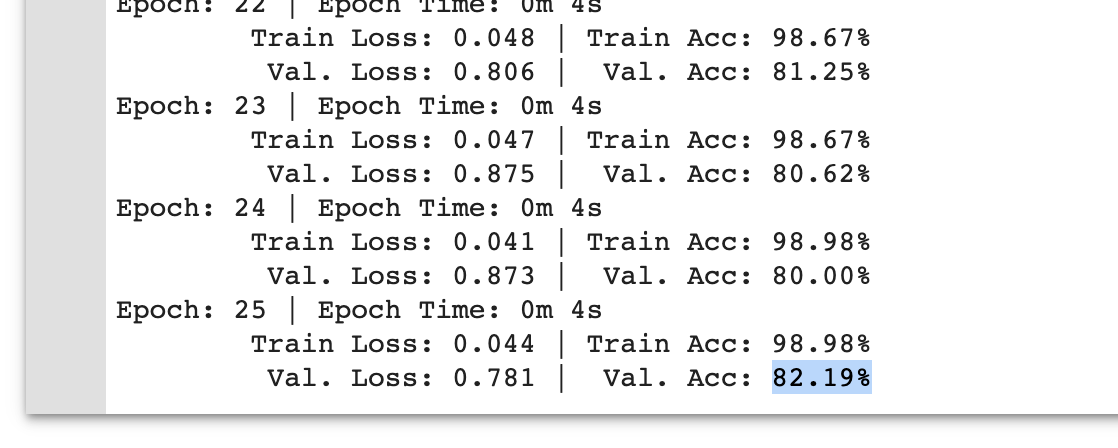

## USER Input : Prediction 모듈 설정
- 입력기사를 받아들여서 분류를 테스트 하는 모듈 작성

#### 네이버 뉴스 labels
    - 정치(0), 경제(1), 사회(2), 생활/문화(3), 세계(4), 기술/IT(5), 연예(6), 스포츠(7) 

In [0]:
def predict_news(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok for tok in tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    preds = torch.sigmoid(model(tensor, length_tensor))
    print(preds)
    max_preds = preds.argmax(dim = 1)
    # print(max_preds)
    return max_preds.item()

In [0]:

## 다음 문장으로 각각 테스트
## 정답은 6, 4, 0, 1, 2, 7, 5, 3
## LABEL.vocab에 담긴 라벨들은 각각 '1': 0, '2': 1, '3': 2, '4': 3, '0': 4, '7': 5, '6': 6, '5': 7이므로
## 정답의 결과값은 6, 3, 4, 0, 1, 5, 7, 2 여야한다.

## LABEL.vocab 값은 build_vocab을 할 때마다 달라지기 때문에 신경써야한다.


sentence1 = "화보 촬영 후 진행 된 인터뷰에서 처음으로 이름이 실시간 검색어에 올랐을 때의 소감을 묻자 처음엔 무서웠다. 내가 뭘 잘못했나 싶었다. 주변 사람들이 기뻐하는 것을 보며 긍정적으로 생각하게 됐다. 신원호 감독님은 숙명으로 받아 들이라고 하시더라라며 웃었다. 함께 출연한 배우들의 이야기도 빠질 수 없었다. 전미도는 다른 여성 출연자들과도 서로 얼굴 한 번 더 보려고 노력한다. 민하(안은진)와 겨울이(신현빈)와는 얼마 전에는 셋이 따로 처음으로 만나기도 했다. '99즈'와는 드라마가 끝난 후에도 한 달에 한 번은 만나서 합주를 한 상태다. 서로 정이 많이 들었다.라고 말하며 끈끈한 동료애를 드러냈다."
sentence2 = "아베 정권이 자의적으로 검찰 고위직 인사의 정년(停年)을 결정할 수 있게 하는 검찰청법 개정안에 대해 트위터를 중심으로 반대 여론이 집결됐다. 아사히 신문은 이 법안에 대해 리트윗을 포함한 반대가 700만건 이상 나타났다고 전했다. “코로나 사태로 어수선한 틈을 타서 독소조항이 들어있는 법안을 통과시키려 한다”는 여론이 순식간에 확산된 것이다. 입헌 민주당의 에다노 유키오(枝野幸男)대표는 아베 총리에게 “코로나 감염 확대 사태의 혼잡을 틈타서 불난 곳에서 도둑질 하려 한다”고 비판했다."
sentence3 = "문재인 대통령은 18일 광주광역시 5·18민주광장에서 열린 제40주년 5·18민주화운동 기념식 기념사에서 “5·18 진상 규명에 최선을 다하겠다”며 “지난 12일 본격적으로 활동을 시작한 ‘5·18진상규명조사위원회’가 남겨진 진실을 낱낱이 밝힐 수 있도록 지원을 아끼지 않겠다”고 말했다."
sentence4 = "이 같은 전망과 함께 구직자 중 76.9%는 ‘올해 안에 취업을 못할까 불안감을 느낀다’고 답했다. 불안감을 느끼는 주요 이유는 ‘경기불황으로 채용을 진행하는 기업 자체가 적을 것 같아서(71.7%)’, ‘상반기 채용 축소로 경쟁률이 더 높아질 것 같아서(50.0%)’, ‘기업들의 실적이 좋지 않다는 뉴스를 접해서(13.2%)’ 등이었다."
sentence5 = "앞서 정부는 지난달 14일부터 재양성자가 지역 사회에서 또 다시 전파를 일으킬 것을 우려해 이들이 처음 확진 판정을 받았을 때처럼 병원 또는 집에 격리시켜왔다. 하지만 재양성자의 감염력이 없다는 판단에 따라 이들을 확진 환자에 준해 관리하지는 않겠다는 방침을 밝혔다. 윤태호 중앙사고수습본부 방역총괄반장은 “19일 0시부터 재양성자는 직장, 학교 등에 복귀한 경우 진단검사 결과 ‘음성’을 확인하지 않아도 되는 것으로 지침을 변경할 것”이라고 말했다."
sentence6 = "손흥민은 EPL 통산 151경기서 51골을 기록했다. AFC는 “지난 4시즌 동안 모든 대회를 통틀어 75골을 넣으며 세계적인 명성을 얻었다”며 “지난 시즌엔 토트넘의 챔피언스리그 결승행에 핵심 역할을 했다”고 조명했다. EPL 통산 187경기서 15골을 기록한 기성용에 대해선 “200경기에 가까운 출전과 3개의 팀에서 정식선수로 뛰며 영국에서 멋진 커리어를 누렸다”며 “본업이 미드필더인 그는 2013년 잉글랜드 리그컵 결승서 중앙 수비수로 뛰며 구단 108년 역사상 유일한 메이저 트로피 획득을 도왔다”고 치켜세웠다."
sentence7 = "LG전자는 최근 동영상 감상을 즐기는 사용자가 많아 Q61에 6.5인치 대화면 디스플레이를 탑재하고 전면 베젤도 최소화했다. 홀인(펀치홀) 디스플레이로 카메라가 화면에서 차지하는 면적도 최소화했다. 또 Q61에는 동영상 시청, 웹서핑 등 멀티미디어 환경에서 장시간 사용할 수 있도록 4000mAh(밀리암페어시)의 대용량 배터리가 들어갔다. LG전자는 “다양한 가격대와 디자인의 제품을 지속적으로 출시해 고객 선택 폭을 넓혀가겠다”고 밝혔다."
sentence8 = "난데없이 삼성동이 외신(外信)의 집중 관심 지역으로 떠올랐다. 전광판 때문이다. 더 정확히는 케이팝광장 앞 코엑스 아티움 건물에 있는 대형 전광판에서 흘러나오는 미디어아트 ‘Wave’ 때문이다. 매시 정각과 30분마다 대략 1분 동안 시퍼런 파도가 요동치는 영상인데, 7K 고해상도로 펼쳐지는 ‘물쇼’를 투명 유리통 안에 가두는 연출을 통해 도심과의 접점을 극대화했다. 지난달 처음 설치돼 최근 유튜브 등을 통해 퍼져나가면서 특히 해외 소셜미디어가 들끓었고, 미국 포브스나 영국 데일리메일 등 유수의 매체도 앞다퉈 보도했다. CNN은 지난 20일 “거대한 입체 파도가 강남을 휩쓸었다”고 보도했다."

sentences = [sentence1, sentence2, sentence3, sentence4, sentence5, sentence6, sentence7, sentence8]
for sent in sentences:
   print(predict_news(model, sent))


tensor([[0.1283, 0.3581, 0.9100, 0.3127, 0.8112, 0.3387, 0.1154, 0.4392]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
2
tensor([[0.1635, 0.1641, 0.3039, 0.9165, 0.1120, 0.1547, 0.9864, 0.7430]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
6
tensor([[0.1292, 0.1404, 0.3004, 0.9223, 0.0448, 0.1395, 0.9933, 0.8596]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
6
tensor([[0.0525, 0.9490, 0.4676, 0.9962, 0.0136, 0.6807, 0.2010, 0.1332]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
3
tensor([[0.0136, 0.2125, 0.7128, 0.9204, 0.0137, 0.8234, 0.9574, 0.6399]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
6
tensor([[1.0000, 0.6862, 0.8422, 0.0410, 0.6714, 0.0079, 0.0097, 0.0329]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
0
tensor([[0.1903, 0.9995, 0.4717, 0.8873, 0.0255, 0.3965, 0.0412, 0.0409]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
1
tensor([[0.3428, 0.1677, 0.7871, 0.5358, 0.1468, 0.2421, 0.5793, 0.9349]],
       device='cuda:0', grad_

## Adamax

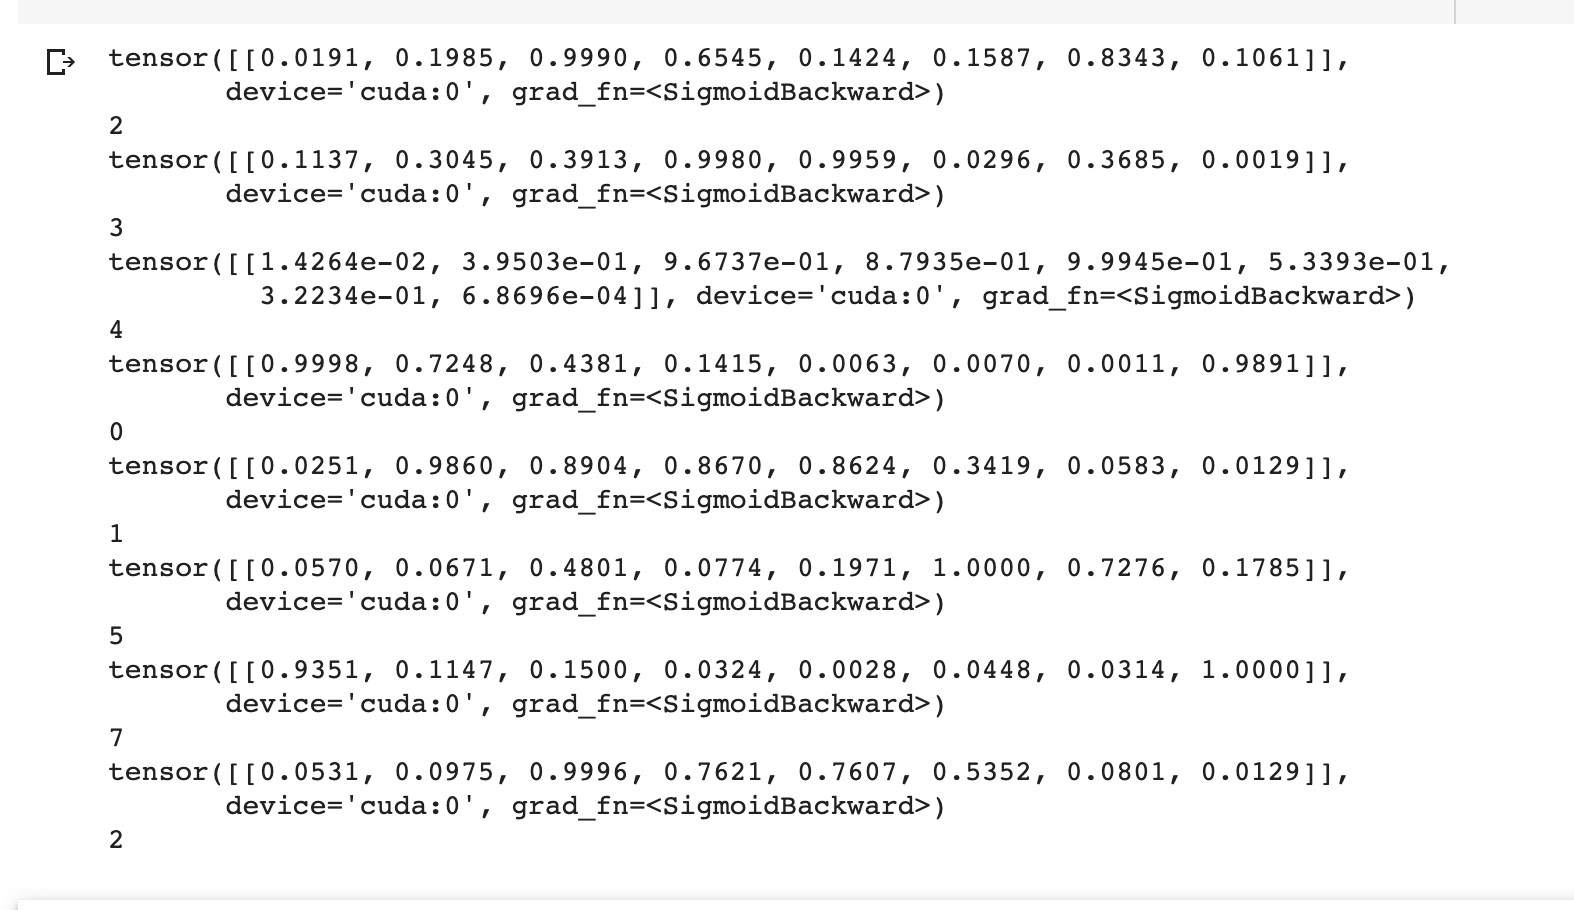

## 발견 1: Adamax 사용시엔 sentence1 제외하고 모두 잘 분류했다.

Adam 사용시엔 sentence1 sentence2 를 틀렸는데, 이에 대해서 분석한 결과는 다음과 같다.

## 발견 2: sentence1(연예)를 생활/문화로 sentence2(세계)를 정치로 분류함을 발견했다.
이에 대해 좀 더 분석해보기 위해 다음과 같이 직접 문장을 넣어 테스트해보았다. 

# 1. 세계를 정치로 혼동하는 경우

- 세계는 예측값이 3이지만 정치의 예측값인 4가 나왔다.

- 이는 세계와 정치 기사의 vocab에 모두 국가명과 국가지도자 이름이 다수 포함되어 있기 때문일 것이다.

- 국가 이름이 더 비중있게 등장할 때는 세계로 분류할 것이라 예측했고 국가간의 유권 분쟁에 대한 기사와 김정은과 트럼프가 서로에 대해 언급하는 등장하는 기사로 살험해보았다. 실제로 국가이름이 많이 나올 때 세계로 분류했다.

###결론: 여러 개의 국가 명이 동시에 등장할 때 '세계'로 잘 분류한다. 

In [0]:
# 잘 분류한 문장: 국가 명이 여러 개 들어가 있다 (일본, 인도, 중국)
sentence1 = "일본과 인도가 중국과 오랫동안 영유권 분쟁 중인 가운데 미국도 중국과 무역 전쟁을 벌이며 영유권 문제가 복잡하게 얽힌 남중국해에서 중국의 도발적인 행위에 대해 우려를 거듭 표명했다. 아베 총리는 “일본, 미국, 인도는 근본 가치와 전략적 이해를 공유한다”며 “삼국이 협력하면 이 지역은 물론 전 세계에 더 큰 번영과 안정을 가져올 것”이라고 말했다.모디 총리는 일본, 미국, 인도의 첫 알파벳을 조합하면 힌두어로 장수를 의미하는 “JAI”라는 점을 언급했다. 트럼프 정부는 아베 총리가 모든 아시아가 항행과 무역에 열려 있어야 한다며 오랫동안 사용해온 “자유롭고 개방적인 인도 태평양”이라는 문구를 자주 사용하고 있다."
# 잘 분류하지 못한 문장
sentence2 = "앞서 지난달 21일 트럼프 대통령은 김 위원장의 건강 이상설과 관련해 우리는 모른다. 나는 그가 잘 있기를 바란다고 말했었다. 이틀 뒤인 23일에는 ‘위중설에 대해 미 당국이 주시하고 있다’는 CNN 보도에 대해 오래된 문서를 쓴 것이라고 들었다며 부정확한 뉴스라고 지적했다."
print(predict_news(model, sentence1))
print(predict_news(model, sentence2))

tensor([[0.2438, 0.1085, 0.6963, 0.9999, 0.2698, 0.0560, 0.0815, 0.0096]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
3
tensor([[0.1877, 0.3157, 0.3209, 0.9759, 0.9968, 0.0749, 0.2778, 0.0074]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
4


# 2. 연예를 스포츠로 혼동하는 경우

- 연예는 예측값이 6이지만 스포츠의 예측값인 5가 나왔다.

- 이는 연예와 스포츠 기사의 vocab에 모두 유명인과 관련된 사건과 수상실적 등이 다수 포함되어 있기 때문일 것이다.

- 연예인의 이름이 더 비중있게 등장할 때는 연예로 분류할 것이라 예측했고 연예인이 소속된 모델 에이전시에 대한 기사와 기생충 수상에 대한 기사로 실험해보았다. 실제로 연예인이름이 많이 나올 때 연예로 분류했다.

###결론: 여러 개의 연예인 이름이 동시에 등장할 때 '연예'로 잘 분류한다. 

In [0]:
# 잘 분류한 문장: 연예인의 실명(차승원, 강동원, 김우빈)이 들어가 있다
sentence1 = "YG는 모델 에이전시 K플러스와 협력해 모델 출신 배우도 키워내려 한다. 지난달 YG는 K플러스와 전략적 제휴와 지분투자 계약을 체결했다. 당시 YG 관계자는 “차승원, 강동원, 김우빈 등 모델 출신 스타가 드라마·영화에서 맹활약 중이다”며 “제2의 차승원, 김우빈을 탄생시킬 것”이라고 협력 이유를 밝혔다."
# 잘 분류하지 못한 문장
sentence2 = "봉준호 감독의 영화 <기생충>이 25일(현지시각) 제72회 칸 국제영화제에서 한국영화 사상 최초로 최고상인 황금종려상을 수상했다. 한국영화가 칸 국제영화제에서 본상을 받은 것은 지난 2010년 이창동 감독의 <시>가 각본상을 받은 뒤 9년 만이다."
print(predict_news(model, sentence1))
print(predict_news(model, sentence2))

tensor([[0.0448, 0.0320, 0.9723, 0.0410, 0.0173, 0.6051, 0.9883, 0.9852]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
6
tensor([[0.1077, 0.0132, 0.9654, 0.5655, 0.0646, 0.9982, 0.1808, 0.2076]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
5


##참고

train_data에 들어있는 어휘 중 각 라벨에 해당하는 것들을 보기 위해 다음과 같은 함수를 사용했다.

예를 들어 '연예' 라벨에 해당하는 어휘들을 보면 정려원, 이상민, 백지은, 곽윤기, 김강우, 유이, 박진영, 백종원, 김흥국 등의 이름이 많이 있음을 알 수 있다.

In [0]:
def train_dataset_by_label(label):
  cnt = 0
  for i in range(len(train_data)):
    if train_data[i].label == label:
      cnt += 1
      print(train_data[i].news)
  return cnt

In [0]:
train_dataset_by_label("6")

['종영', '남편', '오작', '김강우', '유이', '진짜', '결혼', '해피엔딩', '종합', '헤럴드', '고승', '기자', '유이', '김강우', '사랑', '확인', '진짜', '결혼', '방송', '주말', '드라마', '남편', '오작', '한승주', '유이', '오작', '김강우', '사랑', '결실', '모습', '에릭', '정상훈', '작두', '문제', '시골', '그냥', '서울', '작두', '한승주', '얘기', '신경', '그었다', '한승주', '본부장', '방송국', '입사', '제안', '거절', '확답', '다시', '고민', '이후', '작두', '한승주', '방송국', '얘기', '사랑', '진짜', '결혼', '진심', '한승주', '방송국', '입사', '결정', '작두', '한승주', '서울', '결심', '작두', '한승주', '시골', '가지', '거듭', '이후', '한승주', '작두', '자기', '자리', '작두', '한승주', '선택', '대꾸', '작두', '시골', '가기', '결정', '한승주', '작두', '주말', '한승주', '작두', '한승주', '갑자기', '작두', '사실', '사람', '연락', '타이밍', '한승주', '작두', '전화', '오늘', '눈물', '에릭', '곧장', '작두', '작두', '서울', '한승주', '결혼', '혼자', '작두', '면서', '사랑', '작두', '한승주', '진심', '확인', '키스', '마침내', '진짜', '결혼', '사람', '첫날', '맞이', '한승주', '구라', '마을', '할머니', '김간', '오미연', '나중', '박혜진', '이비', '방은희', '이야기', '위해', '다시', '카메라', '또한', '한승주', '오작', '이름', '독립', '다큐', '프로그램', '대상', '사람', '두메산골', '나날', '서로', '애정']
['연예가중계', '박일', '김흥국', '폭행', '미투', '음해', '매경

166